<a href="https://colab.research.google.com/github/blackkolly/Generator_CTGAN/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary statistics:
               time       nof_ue      dl_brate      ul_brate     proc_rmem  \
count  7.500000e+03  7500.000000   7500.000000  7.500000e+03  7.500000e+03   
mean   1.083748e+06     5.000533   6093.129519  9.287996e+05  4.500000e-01   
std    2.165212e+03     0.023089   5845.246103  3.510798e+05  5.201742e-14   
min    1.080000e+06     5.000000      0.000000  0.000000e+00  4.500000e-01   
25%    1.081870e+06     5.000000   2947.368408  6.893333e+05  4.500000e-01   
50%    1.083750e+06     5.000000   4307.692383  9.191111e+05  4.500000e-01   
75%    1.085620e+06     5.000000   9333.333008  1.181714e+06  4.500000e-01   
max    1.087500e+06     6.000000  66666.664062  3.192000e+06  4.500000e-01   

       proc_rmem_kB  proc_vmem_kB  sys_mem  system_load  thread_count  ...  \
count        7500.0        7500.0   7500.0  7500.000000        7500.0  ...   
mean       884596.0     1656800.0     89.0     1.280436          15.0  ...   
std             0.0           0.0      0.0 

<ipython-input-1-3bd009a419d1>:267: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[column], label='Original', fill=True)


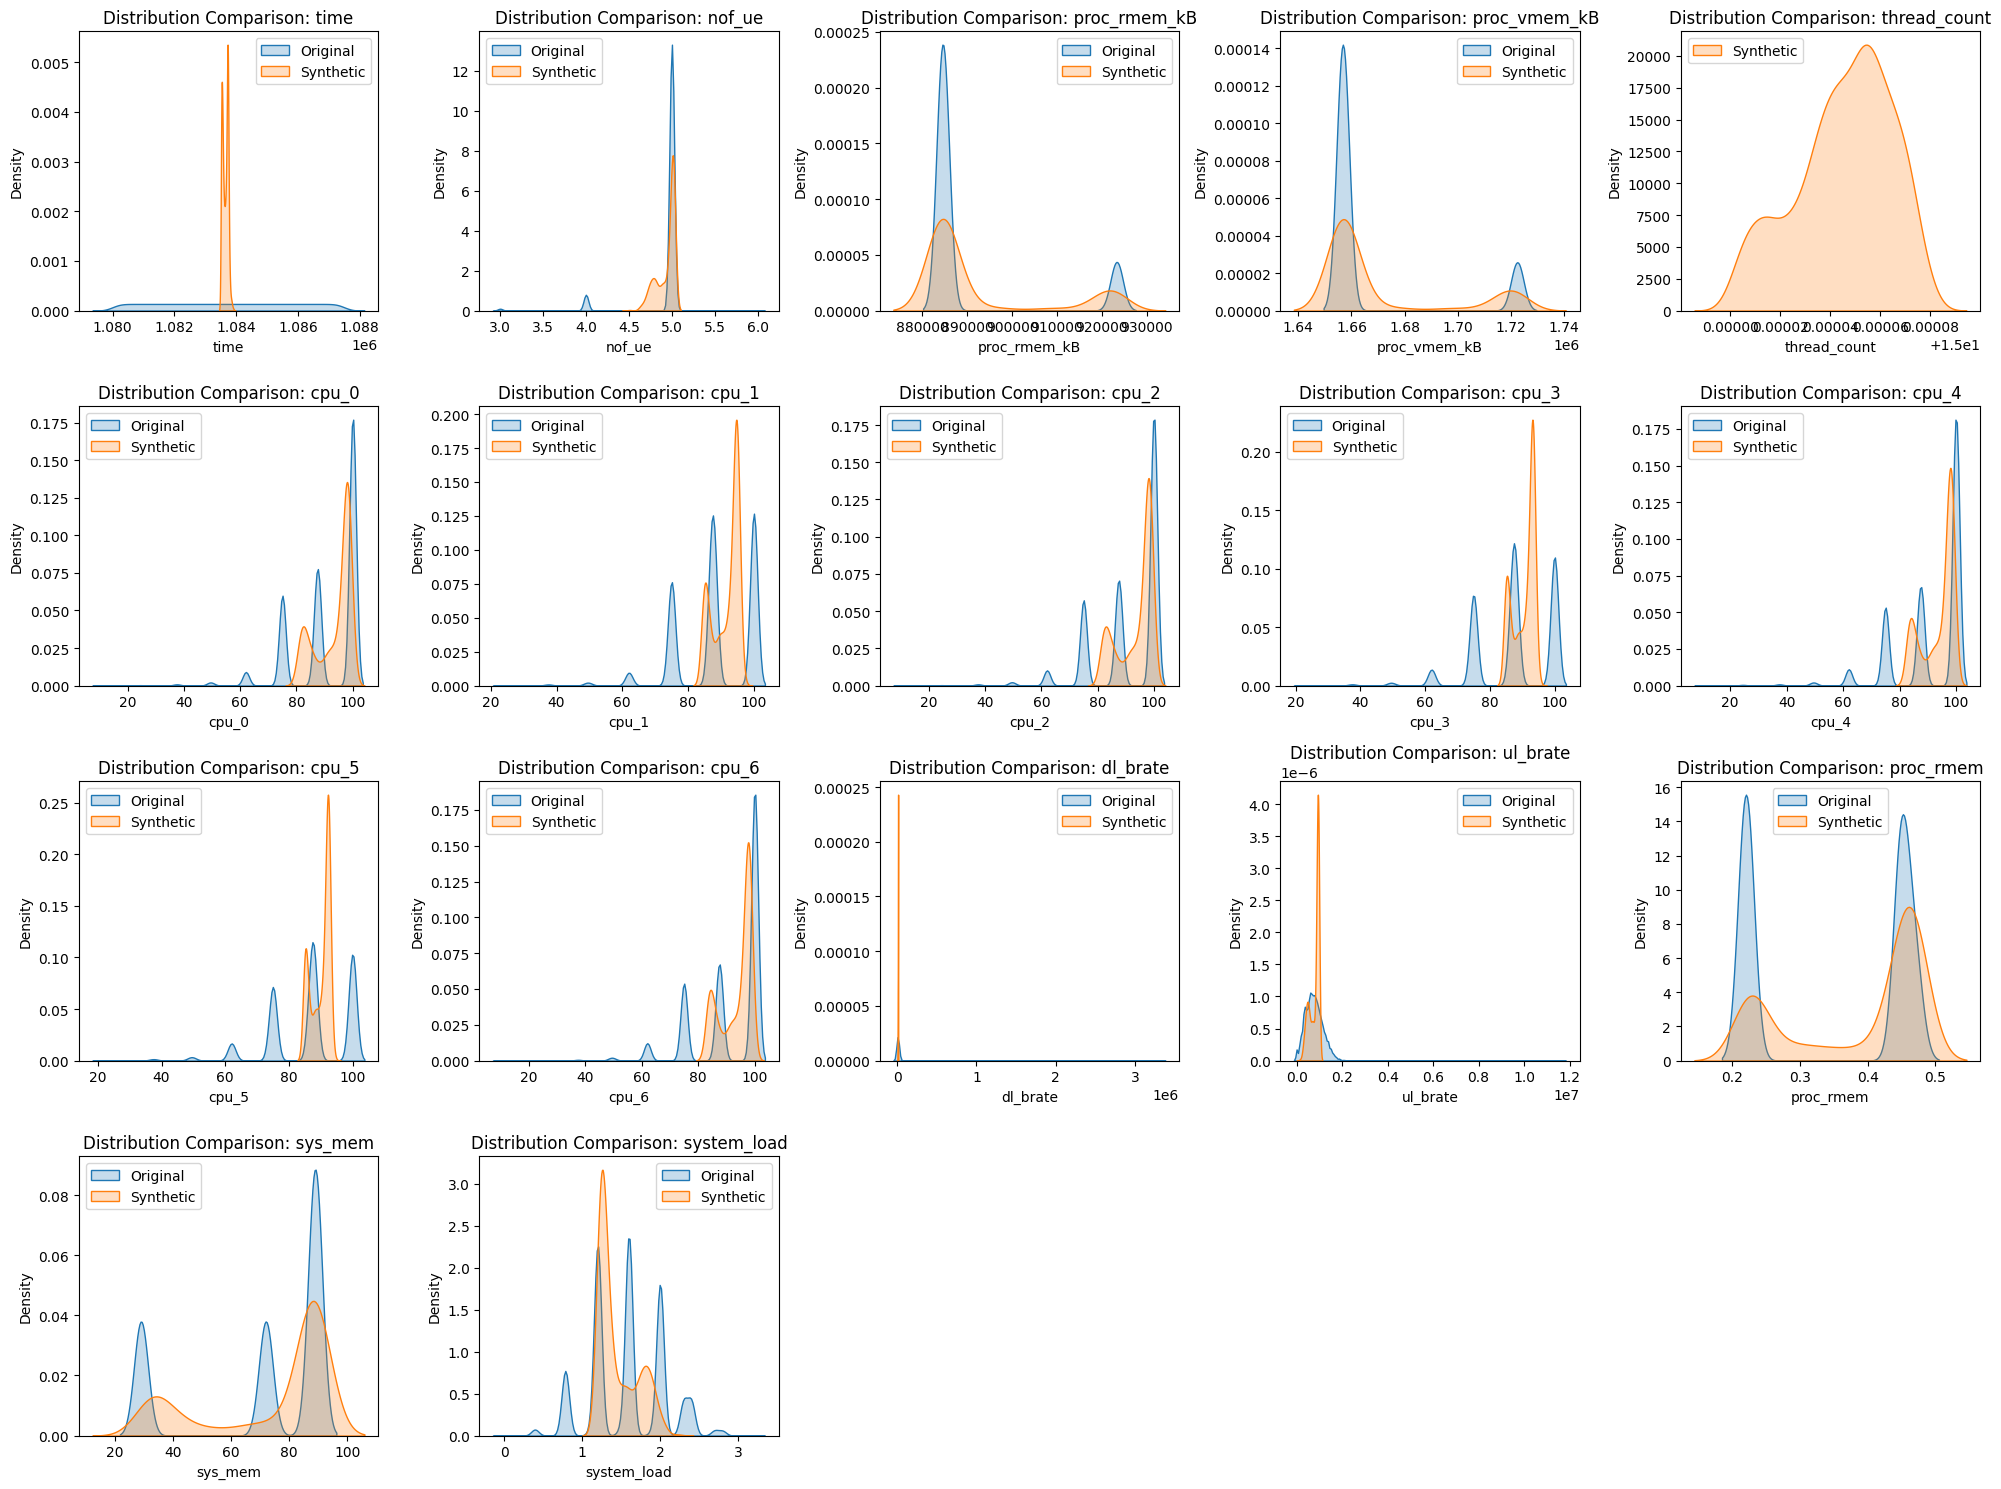

ValueError: Found input variables with inconsistent numbers of samples: [97500, 1000]

In [1]:
import requests
import pandas as pd
import logging
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('pipeline.log'),  # Log to a file
        logging.StreamHandler()  # Log to console
    ]
)

# Function to get file names from a GitHub directory using the GitHub API
def get_github_file_urls(repo, path, branch="main"):
    """Fetch CSV file URLs from a GitHub directory."""
    api_url = f"https://api.github.com/repos/{repo}/contents/{path}"
    try:
        response = requests.get(api_url)
        response.raise_for_status()  # Raise an error for bad status codes
        files = response.json()
        file_urls = [
            f"https://raw.githubusercontent.com/{repo}/{branch}/{path}/{file['name']}"
            for file in files
            if file['type'] == 'file' and file['name'].endswith('.csv')
        ]
        return file_urls
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to retrieve directory {path}: {e}")
        return []

# Function to clean a DataFrame
def clean_data(df, fill_value=0, threshold=0.5):
    """Clean a DataFrame by handling missing values and duplicates."""
    logging.info("\nMissing values per column before cleaning:")
    logging.info(df.isnull().sum())

    logging.info("\nNumber of duplicate rows before cleaning: %d", df.duplicated().sum())

    # Drop columns with excessive missing values
    df = df.dropna(axis=1, thresh=int(threshold * len(df)))

    # Fill missing values with the specified placeholder
    df_filled = df.fillna(fill_value)

    # Drop rows where all values are missing
    df_cleaned = df_filled.dropna(how='all')

    # Drop duplicate rows, keeping the first occurrence
    df_cleaned = df_cleaned.drop_duplicates(keep='first')

    logging.info("\nMissing values per column after cleaning:")
    logging.info(df_cleaned.isnull().sum())
    logging.info("Number of duplicate rows after cleaning: %d", df_cleaned.duplicated().sum())

    return df_cleaned

# Function to download and clean CSV files
def process_csv_files(urls):
    """Download and clean CSV files."""
    dataframes = []
    for url in urls:
        logging.info(f"Downloading and cleaning file from: {url}")
        try:
            df = pd.read_csv(url, delimiter=';', header=0)
            df_cleaned = clean_data(df)
            dataframes.append(df_cleaned)
        except Exception as e:
            logging.error(f"Error reading or cleaning CSV from {url}: {e}")
    return dataframes

# Function to verify data cleanliness
def verify_data_cleanliness(dataframes):
    """Verify the cleanliness of cleaned DataFrames."""
    for i, df in enumerate(dataframes):
        logging.info(f"\nVerifying DataFrame {i + 1}:")

        # Check for missing values
        logging.info("Missing values per column:")
        logging.info(df.isnull().sum())

        # Check for duplicates
        logging.info("Number of duplicate rows:", df.duplicated().sum())

        # Check data types
        logging.info("Data types:")
        logging.info(df.dtypes)

        # Check for outliers
        print("Summary statistics:")
        print(df.describe())

        # Check categorical data consistency
        for column in df.select_dtypes(include=['object']):
            logging.info(f"Unique values in {column}:")
            logging.info(df[column].unique())

        # Check for negative values in numeric columns
        for column in df.select_dtypes(include=[np.number]):
            logging.info(f"Negative values in {column}:")
            logging.info(df[df[column] < 0])

        logging.info("\n" + "="*50 + "\n")

# Helper function to scale data
def scale_data(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data), scaler

# Example: Get CSV file URLs from multiple GitHub repository directories
repo = "cedric-cnam/5G3E-dataset"
directories = [
    "SampleData/RAN_level/site1_2",
    "SampleData/RAN_level/site3",
    "SampleData/RAN_level/site4",
]

# Fetch all CSV file URLs
all_csv_file_urls = []
for directory in directories:
    logging.info(f"Fetching CSV files from directory: {directory}")
    csv_file_urls = get_github_file_urls(repo, directory)
    if csv_file_urls:
        all_csv_file_urls.extend(csv_file_urls)
    else:
        logging.warning(f"No CSV files found in directory: {directory}")

# Print the collected CSV URLs to verify
if not all_csv_file_urls:
    logging.error("No CSV files found in any of the specified directories.")
else:
    for url in all_csv_file_urls:
        logging.info(url)

# Separate File1 and File2 URLs (example: filter URLs containing 'enb')
file1_urls = [url for url in all_csv_file_urls if 'enb' in url]

# Process File1 URLs
file1_dataframes = process_csv_files(file1_urls)

# Verify cleanliness of cleaned DataFrames
verify_data_cleanliness(file1_dataframes)

# Combine all DataFrames
combined_df = pd.concat(file1_dataframes, ignore_index=True)

# Select relevant columns for the model
data = combined_df[['time', 'nof_ue', 'proc_rmem_kB', 'proc_vmem_kB', 'thread_count', 'cpu_0', 'cpu_1', 'cpu_2', 'cpu_3', 'cpu_4', 'cpu_5', 'cpu_6', 'dl_brate', 'ul_brate', 'proc_rmem', 'sys_mem', 'system_load']]

# Scale the data
scaled_data, scaler = scale_data(data)

# Convert to numpy array
scaled_data = np.array(scaled_data)

# Step 2: Build the VAE Model
latent_dim = 10  # Size of the latent space

# Encoder with dropout and regularization
inputs = tf.keras.Input(shape=(scaled_data.shape[1],))
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder with dropout and regularization
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder_inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(scaled_data.shape[1], activation='sigmoid')(x)

# Define encoder and decoder models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_inputs, outputs, name='decoder')

# Custom VAE layer to compute the loss
class VAELossLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs, outputs, z_mean, z_log_var):
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))  # Mean squared error
        reconstruction_loss *= inputs.shape[1]  # Scale by the number of features

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        # Total loss
        self.add_loss(reconstruction_loss + kl_loss)
        return outputs  # Return outputs for the model

# Define VAE model
outputs = decoder(encoder(inputs)[2])

# Add the custom loss layer
vae_outputs = VAELossLayer()(inputs, outputs, z_mean, z_log_var)
vae = Model(inputs, vae_outputs, name='vae')

# Compile the model
vae.compile(optimizer='adam')

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Step 3: Train the VAE Model
history = vae.fit(
    scaled_data,
    epochs=100,  # Increased epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Step 4: Generate Synthetic Data
num_samples = 1000  # Number of synthetic samples to generate
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_data = decoder.predict(random_latent_vectors)

# Inverse transform to original scale
generated_data = scaler.inverse_transform(generated_data)

# Convert to DataFrame
synthetic_df = pd.DataFrame(generated_data, columns=data.columns)
print("Synthetic Data:")
print(synthetic_df.head())

# Step 5: Evaluate the Synthetic Data
# Compare means
print("\nOriginal Data Mean:")
print(data.mean())

print("\nSynthetic Data Mean:")
print(synthetic_df.mean())

# Compare distributions
plt.figure(figsize=(20, 15))
for i, column in enumerate(data.columns):
    plt.subplot(4, 5, i + 1)  # Adjust the subplot grid as needed
    sns.kdeplot(data[column], label='Original', fill=True)
    sns.kdeplot(synthetic_df[column], label='Synthetic', fill=True)
    plt.legend()
    plt.title(f'Distribution Comparison: {column}')
    plt.tight_layout()

plt.show()

# Calculate MSE for each feature
mse_results = {}
for column in data.columns:
    mse = mean_squared_error(data[column], synthetic_df[column])
    mse_results[column] = mse

# Print MSE results
print("\nMean Squared Error (MSE) for Each Feature:")
for column, mse in mse_results.items():
    print(f"{column}: {mse:.4f}")

# Save the encoder and decoder models
save_path = '/content/VAE_Models/'

# Save the models
encoder.save(save_path + 'encoder_model.keras')
decoder.save(save_path + 'decoder_model.keras')

vae.save(save_path +'vae_model.keras')


print("Models saved successfully!")


Summary statistics:
               time       nof_ue      dl_brate      ul_brate     proc_rmem  \
count  7.500000e+03  7500.000000   7500.000000  7.500000e+03  7.500000e+03   
mean   1.083748e+06     5.000533   6093.129519  9.287996e+05  4.500000e-01   
std    2.165212e+03     0.023089   5845.246103  3.510798e+05  5.201742e-14   
min    1.080000e+06     5.000000      0.000000  0.000000e+00  4.500000e-01   
25%    1.081870e+06     5.000000   2947.368408  6.893333e+05  4.500000e-01   
50%    1.083750e+06     5.000000   4307.692383  9.191111e+05  4.500000e-01   
75%    1.085620e+06     5.000000   9333.333008  1.181714e+06  4.500000e-01   
max    1.087500e+06     6.000000  66666.664062  3.192000e+06  4.500000e-01   

       proc_rmem_kB  proc_vmem_kB  sys_mem  system_load  thread_count  ...  \
count        7500.0        7500.0   7500.0  7500.000000        7500.0  ...   
mean       884596.0     1656800.0     89.0     1.280436          15.0  ...   
std             0.0           0.0      0.0 

<ipython-input-4-ad2780fc5460>:266: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data[column], label='Original', fill=True)


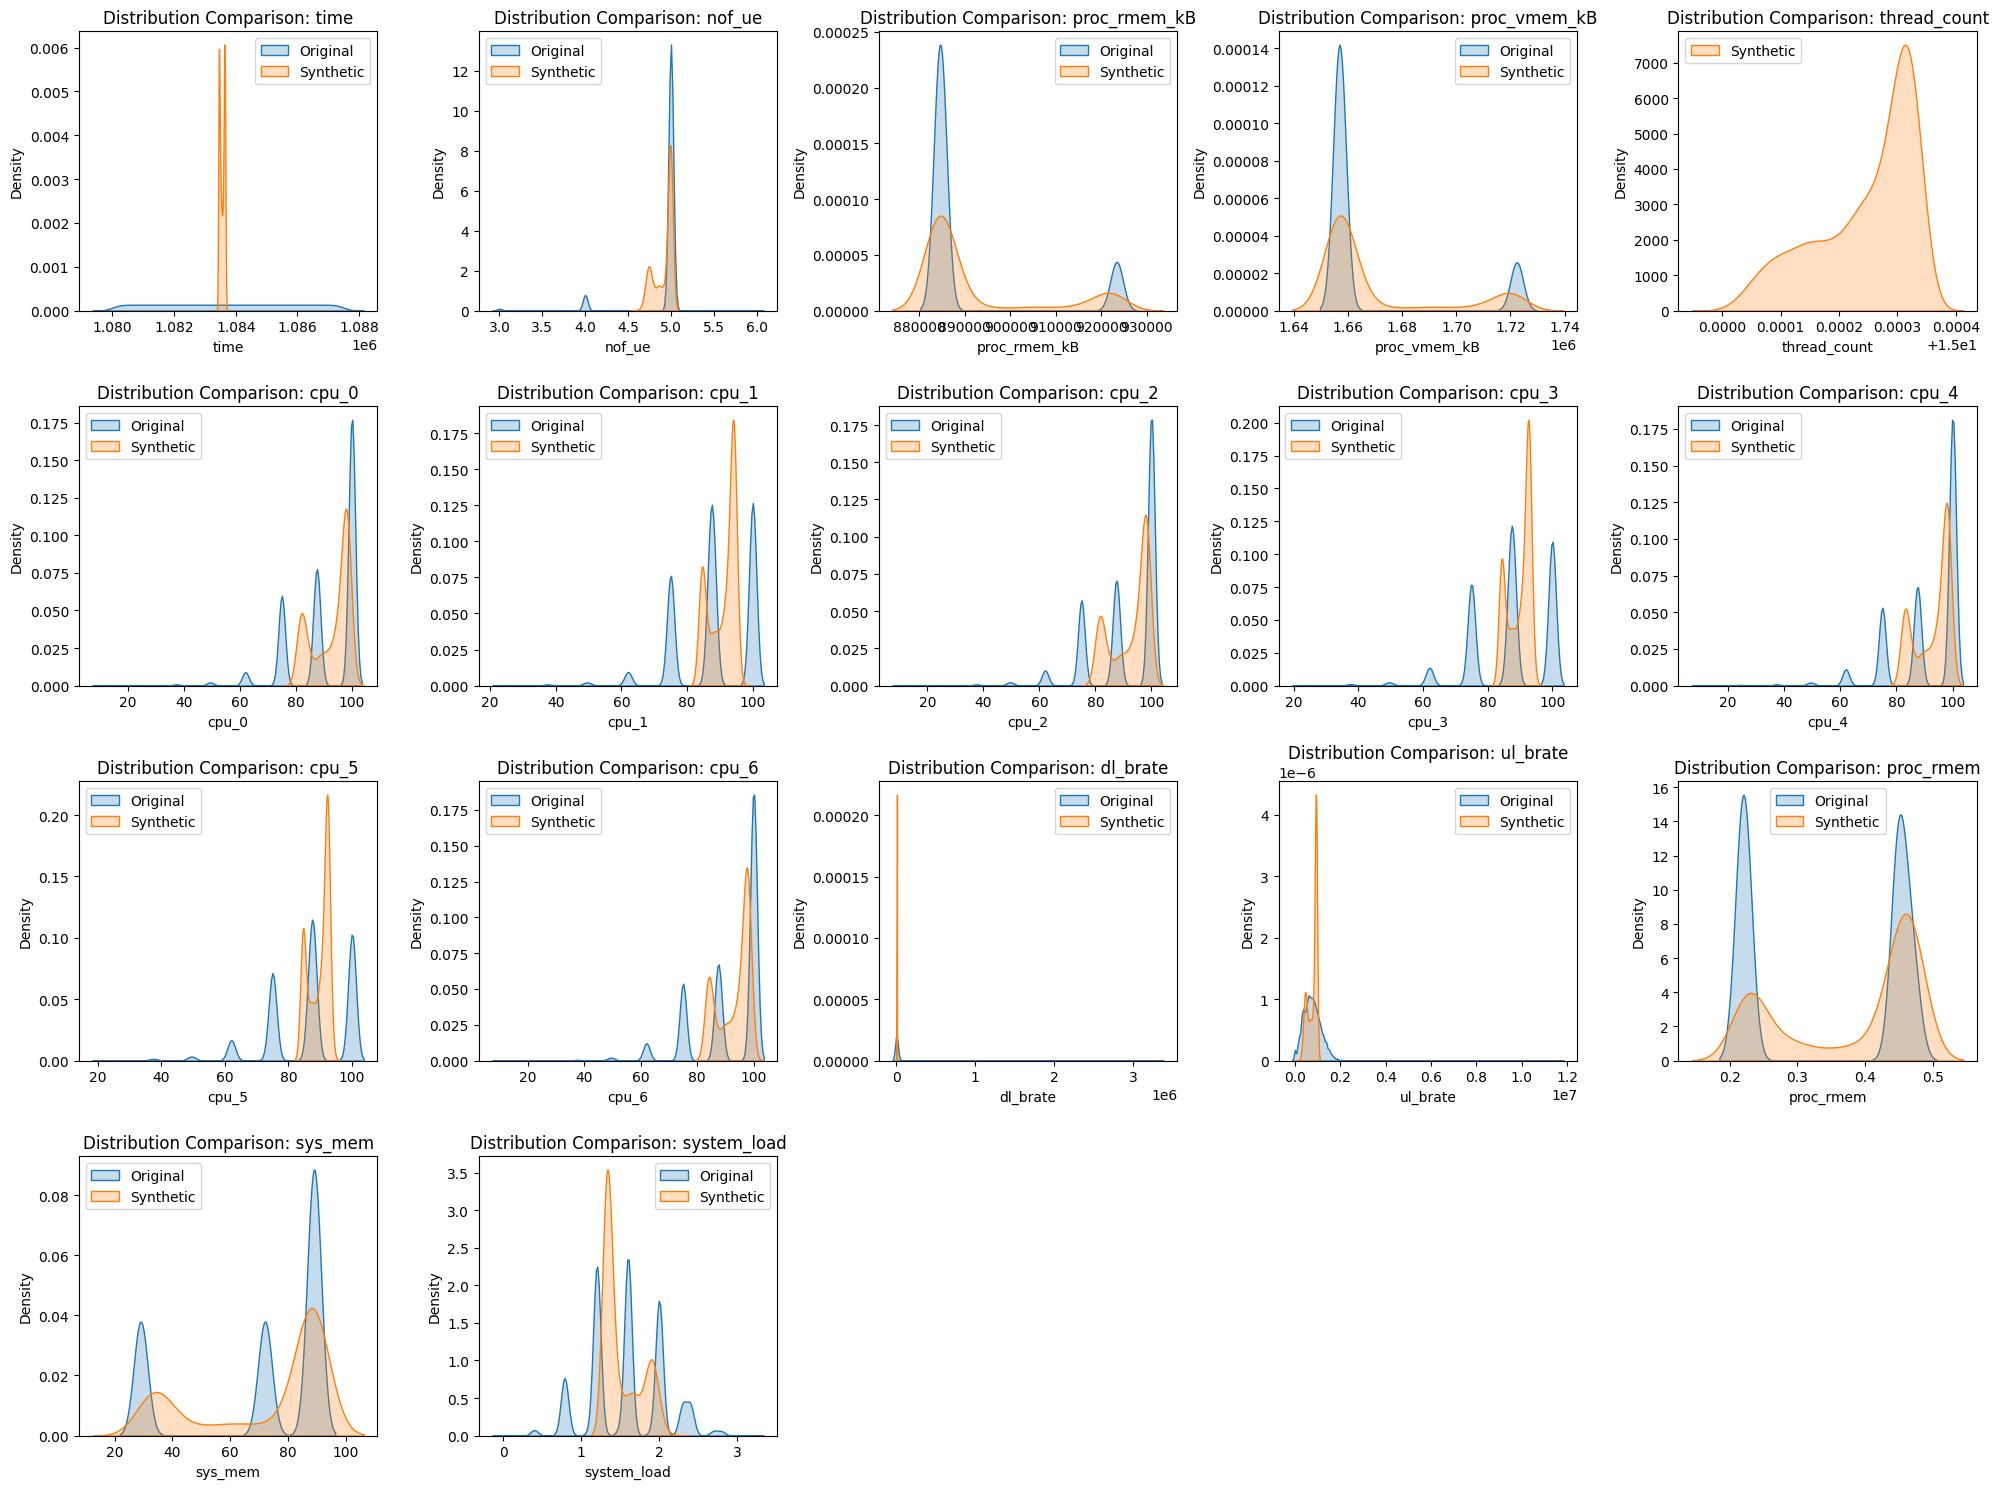

Models saved successfully!


In [4]:
import requests
import pandas as pd
import logging
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('pipeline.log'),  # Log to a file
        logging.StreamHandler()  # Log to console
    ]
)

# Function to get file names from a GitHub directory using the GitHub API
def get_github_file_urls(repo, path, branch="main"):
    """Fetch CSV file URLs from a GitHub directory."""
    api_url = f"https://api.github.com/repos/{repo}/contents/{path}"
    try:
        response = requests.get(api_url)
        response.raise_for_status()  # Raise an error for bad status codes
        files = response.json()
        file_urls = [
            f"https://raw.githubusercontent.com/{repo}/{branch}/{path}/{file['name']}"
            for file in files
            if file['type'] == 'file' and file['name'].endswith('.csv')
        ]
        return file_urls
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to retrieve directory {path}: {e}")
        return []

# Function to clean a DataFrame
def clean_data(df, fill_value=0, threshold=0.5):
    """Clean a DataFrame by handling missing values and duplicates."""
    logging.info("\nMissing values per column before cleaning:")
    logging.info(df.isnull().sum())

    logging.info("\nNumber of duplicate rows before cleaning: %d", df.duplicated().sum())

    # Drop columns with excessive missing values
    df = df.dropna(axis=1, thresh=int(threshold * len(df)))

    # Fill missing values with the specified placeholder
    df_filled = df.fillna(fill_value)

    # Drop rows where all values are missing
    df_cleaned = df_filled.dropna(how='all')

    # Drop duplicate rows, keeping the first occurrence
    df_cleaned = df_cleaned.drop_duplicates(keep='first')

    logging.info("\nMissing values per column after cleaning:")
    logging.info(df_cleaned.isnull().sum())
    logging.info("Number of duplicate rows after cleaning: %d", df_cleaned.duplicated().sum())

    return df_cleaned

# Function to download and clean CSV files
def process_csv_files(urls):
    """Download and clean CSV files."""
    dataframes = []
    for url in urls:
        logging.info(f"Downloading and cleaning file from: {url}")
        try:
            df = pd.read_csv(url, delimiter=';', header=0)
            df_cleaned = clean_data(df)
            dataframes.append(df_cleaned)
        except Exception as e:
            logging.error(f"Error reading or cleaning CSV from {url}: {e}")
    return dataframes

# Function to verify data cleanliness
def verify_data_cleanliness(dataframes):
    """Verify the cleanliness of cleaned DataFrames."""
    for i, df in enumerate(dataframes):
        logging.info(f"\nVerifying DataFrame {i + 1}:")

        # Check for missing values
        logging.info("Missing values per column:")
        logging.info(df.isnull().sum())

        # Check for duplicates
        logging.info("Number of duplicate rows:", df.duplicated().sum())

        # Check data types
        logging.info("Data types:")
        logging.info(df.dtypes)

        # Check for outliers
        print("Summary statistics:")
        print(df.describe())

        # Check categorical data consistency
        for column in df.select_dtypes(include=['object']):
            logging.info(f"Unique values in {column}:")
            logging.info(df[column].unique())

        # Check for negative values in numeric columns
        for column in df.select_dtypes(include=[np.number]):
            logging.info(f"Negative values in {column}:")
            logging.info(df[df[column] < 0])

        logging.info("\n" + "="*50 + "\n")

# Helper function to scale data
def scale_data(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data), scaler

# Example: Get CSV file URLs from multiple GitHub repository directories
repo = "cedric-cnam/5G3E-dataset"
directories = [
    "SampleData/RAN_level/site1_2",
    "SampleData/RAN_level/site3",
    "SampleData/RAN_level/site4",
]

# Fetch all CSV file URLs
all_csv_file_urls = []
for directory in directories:
    logging.info(f"Fetching CSV files from directory: {directory}")
    csv_file_urls = get_github_file_urls(repo, directory)
    if csv_file_urls:
        all_csv_file_urls.extend(csv_file_urls)
    else:
        logging.warning(f"No CSV files found in directory: {directory}")

# Print the collected CSV URLs to verify
if not all_csv_file_urls:
    logging.error("No CSV files found in any of the specified directories.")
else:
    for url in all_csv_file_urls:
        logging.info(url)

# Separate File1 and File2 URLs (example: filter URLs containing 'enb')
file1_urls = [url for url in all_csv_file_urls if 'enb' in url]

# Process File1 URLs
file1_dataframes = process_csv_files(file1_urls)

# Verify cleanliness of cleaned DataFrames
verify_data_cleanliness(file1_dataframes)

# Combine all DataFrames
combined_df = pd.concat(file1_dataframes, ignore_index=True)

# Select relevant columns for the model
data = combined_df[['time', 'nof_ue', 'proc_rmem_kB', 'proc_vmem_kB', 'thread_count', 'cpu_0', 'cpu_1', 'cpu_2', 'cpu_3', 'cpu_4', 'cpu_5', 'cpu_6', 'dl_brate', 'ul_brate', 'proc_rmem', 'sys_mem', 'system_load']]

# Scale the data
scaled_data, scaler = scale_data(data)

# Convert to numpy array
scaled_data = np.array(scaled_data)

# Step 2: Build the VAE Model
latent_dim = 10  # Size of the latent space

# Encoder with dropout and regularization
inputs = tf.keras.Input(shape=(scaled_data.shape[1],))
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder with dropout and regularization
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder_inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(scaled_data.shape[1], activation='sigmoid')(x)

# Define encoder and decoder models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_inputs, outputs, name='decoder')

# Custom VAE layer to compute the loss
class VAELossLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs, outputs, z_mean, z_log_var):
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs))  # Mean squared error
        reconstruction_loss *= inputs.shape[1]  # Scale by the number of features

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        # Total loss
        self.add_loss(reconstruction_loss + kl_loss)
        return outputs  # Return outputs for the model

# Define VAE model
outputs = decoder(encoder(inputs)[2])

# Add the custom loss layer
vae_outputs = VAELossLayer()(inputs, outputs, z_mean, z_log_var)
vae = Model(inputs, vae_outputs, name='vae')

# Compile the model
vae.compile(optimizer='adam')

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Step 3: Train the VAE Model
history = vae.fit(
    scaled_data,
    epochs=100,  # Increased epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Step 4: Generate Synthetic Data
num_samples = 1000  # Number of synthetic samples to generate
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_data = decoder.predict(random_latent_vectors)

# Inverse transform to original scale
generated_data = scaler.inverse_transform(generated_data)

# Convert to DataFrame
synthetic_df = pd.DataFrame(generated_data, columns=data.columns)
print("Synthetic Data:")
print(synthetic_df.head())

# Step 5: Evaluate the Synthetic Data
# Compare means
print("\nOriginal Data Mean:")
print(data.mean())

print("\nSynthetic Data Mean:")
print(synthetic_df.mean())

#Compare distributions for all columns
plt.figure(figsize=(20, 15))
for i, column in enumerate(data.columns):
    plt.subplot(4, 5, i + 1)  # Adjust the subplot grid as needed
    sns.kdeplot(data[column], label='Original', fill=True)
    sns.kdeplot(synthetic_df[column], label='Synthetic', fill=True)
    plt.legend()
    plt.title(f'Distribution Comparison: {column}')
    plt.tight_layout()
plt.show()

# Save the encoder and decoder models
save_path = '/content/VAE_Models/'

# Save the models
encoder.save(save_path + 'encoder_model.keras')
decoder.save(save_path + 'decoder_model.keras')

vae.save(save_path +'vae_model.keras')


print("Models saved successfully!")
